In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rates = tf.placeholder(tf.float32, [None], name='rates')
    training = tf.placeholder(tf.bool, [], name='training')
    return states, actions, targetQs, rates, training

In [4]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [5]:
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [6]:
def model_loss(action_size, hidden_size, states, actions, targetQs, rates, training):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size, training=training)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                              labels=actions_labels)
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    gloss = tf.reduce_mean(neg_log_prob * targetQs) # DPG
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states, training=training)
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, training=training, 
                        reuse=True)
    rates = tf.reshape(rates, shape=[-1, 1])
    dlossA = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                    labels=rates)) # 0-1
    dlossA += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                     labels=tf.nn.sigmoid(targetQs))) # 0-1
    dlossQ = tf.reduce_mean(tf.square(gQs - targetQs)) # DQN
    dlossQ += tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
    return actions_logits, gQs, gloss, dlossA, dlossQ

In [7]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_lossA, d_lossQ, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        d_optA = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossA, var_list=d_vars)
        d_optQ = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossQ, var_list=d_vars)

    return g_opt, d_optA, d_optQ

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rates, self.training = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_lossA, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs, 
            rates=self.rates, training=self.training) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_optA, self.d_optQ = model_opt(g_loss=self.g_loss, 
                                                         d_lossA=self.d_lossA, 
                                                         d_lossQ=self.d_lossQ, 
                                                         g_learning_rate=g_learning_rate, 
                                                         d_learning_rate=d_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
        self.rates = deque(maxlen=max_size) # rates
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), # ==  self.rates
#                                size=batch_size, 
#                                replace=False)
#         return [self.buffer[ii] for ii in idx], [self.rates[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    memory.rates.append(-1) # empty
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        total_reward = 0 # reset
        for idx in range(num_step): # episode length
            if memory.rates[-1-idx] == -1:
                memory.rates[-1-idx] = rate
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [14]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list = [] # goal
rewards_list, gloss_list, dloss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(1111*2):
        total_reward = 0 # each episode
        gloss_batch, dlossA_batch, dlossQ_batch= [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode
        idx_arr = np.arange(memory_size// batch_size)

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
                #print(action)
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1]), 
                                                                          model.training: False})
                action = np.argmax(action_logits) # adding epsilon*noise
                #print(action)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.rates.append(-1) # empty
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.rates[-1-idx] == -1: # double-check the landmark/marked indexes
                        memory.rates[-1-idx] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            percentage = 0.9
            #for idx in range(memory_size// batch_size):
            idx = np.random.choice(idx_arr)
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array(memory.rates)[idx*batch_size:(idx+1)*batch_size]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            states = states[rates >= (np.max(rates)*percentage)]
            actions = actions[rates >= (np.max(rates)*percentage)]
            next_states = next_states[rates >= (np.max(rates)*percentage)]
            rewards = rewards[rates >= (np.max(rates)*percentage)]
            dones = dones[rates >= (np.max(rates)*percentage)]
            rates = rates[rates >= (np.max(rates)*percentage)]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states, 
                                                                   model.training: False})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones) # DQN
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # DPG
            targetQs = rewards + (gamma * nextQs)
            gloss, dlossA, dlossQ, _, _ = sess.run([model.g_loss, model.d_lossA, model.d_lossQ, 
                                                       model.g_opt, model.d_optA], #, model.d_optQ
                                                      feed_dict = {model.states: states, 
                                                                   model.actions: actions,
                                                                   model.targetQs: targetQs, 
                                                                   model.rates: rates, 
                                                                   model.training: True})
            gloss_batch.append(gloss)
            dlossA_batch.append(dlossA)
            dlossQ_batch.append(dlossQ)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dlossA:{:.4f}'.format(np.mean(dlossA_batch)),
              'dlossQ:{:.4f}'.format(np.mean(dlossQ_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        #gloss_list.append([ep, np.mean(gloss_batch)])
        #dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:17.0000 R:17.0000 rate:0.0340 gloss:0.6141 dlossA:1.4773 dlossQ:5.6294 exploreP:0.9983
Episode:1 meanR:23.0000 R:29.0000 rate:0.0580 gloss:0.5842 dlossA:1.4541 dlossQ:5.1124 exploreP:0.9955
Episode:2 meanR:20.0000 R:14.0000 rate:0.0280 gloss:0.5359 dlossA:1.4446 dlossQ:4.8362 exploreP:0.9941
Episode:3 meanR:21.5000 R:26.0000 rate:0.0520 gloss:0.5061 dlossA:1.4275 dlossQ:4.5554 exploreP:0.9915
Episode:4 meanR:21.4000 R:21.0000 rate:0.0420 gloss:0.4663 dlossA:1.4090 dlossQ:4.1001 exploreP:0.9895
Episode:5 meanR:22.6667 R:29.0000 rate:0.0580 gloss:0.4201 dlossA:1.3935 dlossQ:3.7712 exploreP:0.9866
Episode:6 meanR:21.1429 R:12.0000 rate:0.0240 gloss:0.4160 dlossA:1.3921 dlossQ:3.6543 exploreP:0.9855
Episode:7 meanR:20.1250 R:13.0000 rate:0.0260 gloss:0.3595 dlossA:1.3761 dlossQ:3.3787 exploreP:0.9842
Episode:8 meanR:23.7778 R:53.0000 rate:0.1060 gloss:0.2889 dlossA:1.3599 dlossQ:2.9893 exploreP:0.9790
Episode:9 meanR:23.5000 R:21.0000 rate:0.0420 gloss:0.2502 dlossA:1.3413 

Episode:79 meanR:24.9500 R:27.0000 rate:0.0540 gloss:0.0537 dlossA:1.2661 dlossQ:2.8794 exploreP:0.8209
Episode:80 meanR:24.9506 R:25.0000 rate:0.0500 gloss:0.1294 dlossA:1.2820 dlossQ:2.8919 exploreP:0.8188
Episode:81 meanR:25.4390 R:65.0000 rate:0.1300 gloss:0.0998 dlossA:1.2780 dlossQ:2.8018 exploreP:0.8136
Episode:82 meanR:25.3494 R:18.0000 rate:0.0360 gloss:-0.0414 dlossA:1.2450 dlossQ:2.9017 exploreP:0.8122
Episode:83 meanR:25.3810 R:28.0000 rate:0.0560 gloss:0.1552 dlossA:1.2903 dlossQ:3.1801 exploreP:0.8099
Episode:84 meanR:25.2941 R:18.0000 rate:0.0360 gloss:0.1553 dlossA:1.2978 dlossQ:2.6845 exploreP:0.8085
Episode:85 meanR:25.1860 R:16.0000 rate:0.0320 gloss:0.1043 dlossA:1.2743 dlossQ:2.9607 exploreP:0.8072
Episode:86 meanR:25.2299 R:29.0000 rate:0.0580 gloss:0.1605 dlossA:1.2803 dlossQ:2.6358 exploreP:0.8049
Episode:87 meanR:25.3409 R:35.0000 rate:0.0700 gloss:0.1044 dlossA:1.2813 dlossQ:3.1275 exploreP:0.8021
Episode:88 meanR:25.6966 R:57.0000 rate:0.1140 gloss:0.0602 dlo

Episode:158 meanR:36.8100 R:123.0000 rate:0.2460 gloss:0.0901 dlossA:1.2845 dlossQ:3.2119 exploreP:0.6028
Episode:159 meanR:36.9800 R:30.0000 rate:0.0600 gloss:0.1356 dlossA:1.2803 dlossQ:2.9222 exploreP:0.6011
Episode:160 meanR:36.9900 R:16.0000 rate:0.0320 gloss:0.1515 dlossA:1.2828 dlossQ:3.1537 exploreP:0.6001
Episode:161 meanR:37.2500 R:44.0000 rate:0.0880 gloss:0.2035 dlossA:1.2920 dlossQ:2.8141 exploreP:0.5975
Episode:162 meanR:37.2400 R:18.0000 rate:0.0360 gloss:0.0366 dlossA:1.2923 dlossQ:3.0496 exploreP:0.5965
Episode:163 meanR:38.0600 R:111.0000 rate:0.2220 gloss:0.1045 dlossA:1.2739 dlossQ:3.0191 exploreP:0.5900
Episode:164 meanR:38.1900 R:46.0000 rate:0.0920 gloss:0.1865 dlossA:1.2915 dlossQ:2.9605 exploreP:0.5873
Episode:165 meanR:38.0100 R:18.0000 rate:0.0360 gloss:0.2375 dlossA:1.3069 dlossQ:3.0155 exploreP:0.5863
Episode:166 meanR:37.9700 R:32.0000 rate:0.0640 gloss:0.0611 dlossA:1.2656 dlossQ:2.7178 exploreP:0.5844
Episode:167 meanR:38.1600 R:70.0000 rate:0.1400 gloss

Episode:236 meanR:63.1700 R:62.0000 rate:0.1240 gloss:0.2413 dlossA:1.3054 dlossQ:2.6033 exploreP:0.3622
Episode:237 meanR:63.5300 R:87.0000 rate:0.1740 gloss:0.2319 dlossA:1.3032 dlossQ:2.6570 exploreP:0.3592
Episode:238 meanR:63.5300 R:63.0000 rate:0.1260 gloss:0.1905 dlossA:1.2859 dlossQ:2.5921 exploreP:0.3570
Episode:239 meanR:63.7700 R:52.0000 rate:0.1040 gloss:0.2559 dlossA:1.3067 dlossQ:2.7249 exploreP:0.3552
Episode:240 meanR:64.0800 R:70.0000 rate:0.1400 gloss:0.2505 dlossA:1.2961 dlossQ:2.6283 exploreP:0.3528
Episode:241 meanR:64.5800 R:95.0000 rate:0.1900 gloss:0.2397 dlossA:1.3081 dlossQ:2.7394 exploreP:0.3495
Episode:242 meanR:65.4500 R:106.0000 rate:0.2120 gloss:0.2356 dlossA:1.3037 dlossQ:2.6994 exploreP:0.3459
Episode:243 meanR:65.3900 R:58.0000 rate:0.1160 gloss:0.1822 dlossA:1.2939 dlossQ:2.5844 exploreP:0.3440
Episode:244 meanR:65.2500 R:68.0000 rate:0.1360 gloss:0.1965 dlossA:1.2976 dlossQ:2.7367 exploreP:0.3417
Episode:245 meanR:65.5100 R:73.0000 rate:0.1460 gloss:

Episode:314 meanR:84.5600 R:73.0000 rate:0.1460 gloss:0.2738 dlossA:1.3213 dlossQ:2.5221 exploreP:0.1882
Episode:315 meanR:84.9600 R:62.0000 rate:0.1240 gloss:0.3200 dlossA:1.3286 dlossQ:2.3979 exploreP:0.1871
Episode:316 meanR:85.2500 R:120.0000 rate:0.2400 gloss:0.3314 dlossA:1.3296 dlossQ:2.5195 exploreP:0.1850
Episode:317 meanR:85.7400 R:109.0000 rate:0.2180 gloss:0.3553 dlossA:1.3349 dlossQ:2.4645 exploreP:0.1831
Episode:318 meanR:86.5900 R:169.0000 rate:0.3380 gloss:0.3260 dlossA:1.3274 dlossQ:2.4494 exploreP:0.1802
Episode:319 meanR:87.0000 R:116.0000 rate:0.2320 gloss:0.3233 dlossA:1.3222 dlossQ:2.4453 exploreP:0.1783
Episode:320 meanR:87.6400 R:112.0000 rate:0.2240 gloss:0.3134 dlossA:1.3233 dlossQ:2.4284 exploreP:0.1764
Episode:321 meanR:87.1500 R:81.0000 rate:0.1620 gloss:0.3525 dlossA:1.3372 dlossQ:2.4730 exploreP:0.1750
Episode:322 meanR:87.9400 R:132.0000 rate:0.2640 gloss:0.3083 dlossA:1.3224 dlossQ:2.4782 exploreP:0.1729
Episode:323 meanR:88.0800 R:83.0000 rate:0.1660 g

Episode:392 meanR:120.0400 R:233.0000 rate:0.4660 gloss:0.3767 dlossA:1.3477 dlossQ:2.3139 exploreP:0.0760
Episode:393 meanR:120.1800 R:103.0000 rate:0.2060 gloss:0.3741 dlossA:1.3546 dlossQ:2.3075 exploreP:0.0754
Episode:394 meanR:120.8900 R:143.0000 rate:0.2860 gloss:0.3692 dlossA:1.3499 dlossQ:2.4229 exploreP:0.0744
Episode:395 meanR:121.7400 R:141.0000 rate:0.2820 gloss:0.4076 dlossA:1.3537 dlossQ:2.3370 exploreP:0.0735
Episode:396 meanR:122.2600 R:148.0000 rate:0.2960 gloss:0.3843 dlossA:1.3498 dlossQ:2.2270 exploreP:0.0726
Episode:397 meanR:122.3500 R:134.0000 rate:0.2680 gloss:0.4063 dlossA:1.3504 dlossQ:2.2781 exploreP:0.0718
Episode:398 meanR:124.1300 R:262.0000 rate:0.5240 gloss:0.3837 dlossA:1.3536 dlossQ:2.2226 exploreP:0.0702
Episode:399 meanR:125.4200 R:214.0000 rate:0.4280 gloss:0.4000 dlossA:1.3572 dlossQ:2.2593 exploreP:0.0689
Episode:400 meanR:125.4800 R:79.0000 rate:0.1580 gloss:0.3822 dlossA:1.3434 dlossQ:2.1628 exploreP:0.0684
Episode:401 meanR:126.7100 R:200.0000 

Episode:469 meanR:158.6200 R:158.0000 rate:0.3160 gloss:0.4477 dlossA:1.3709 dlossQ:2.1035 exploreP:0.0302
Episode:470 meanR:158.5000 R:96.0000 rate:0.1920 gloss:0.4667 dlossA:1.3742 dlossQ:2.2113 exploreP:0.0300
Episode:471 meanR:157.0500 R:87.0000 rate:0.1740 gloss:0.4612 dlossA:1.3735 dlossQ:2.1541 exploreP:0.0299
Episode:472 meanR:157.1100 R:100.0000 rate:0.2000 gloss:0.4671 dlossA:1.3721 dlossQ:2.1406 exploreP:0.0297
Episode:473 meanR:156.6500 R:111.0000 rate:0.2220 gloss:0.4650 dlossA:1.3707 dlossQ:2.1474 exploreP:0.0294
Episode:474 meanR:155.4600 R:77.0000 rate:0.1540 gloss:0.4475 dlossA:1.3627 dlossQ:2.0584 exploreP:0.0293
Episode:475 meanR:155.2300 R:107.0000 rate:0.2140 gloss:0.4562 dlossA:1.3663 dlossQ:2.0957 exploreP:0.0291
Episode:476 meanR:156.1000 R:198.0000 rate:0.3960 gloss:0.4588 dlossA:1.3734 dlossQ:2.1617 exploreP:0.0287
Episode:477 meanR:156.0600 R:98.0000 rate:0.1960 gloss:0.4634 dlossA:1.3736 dlossQ:2.1648 exploreP:0.0285
Episode:478 meanR:155.5800 R:93.0000 rate

Episode:546 meanR:127.3400 R:71.0000 rate:0.1420 gloss:0.4770 dlossA:1.3790 dlossQ:2.1157 exploreP:0.0179
Episode:547 meanR:127.3400 R:111.0000 rate:0.2220 gloss:0.4981 dlossA:1.3774 dlossQ:2.1161 exploreP:0.0178
Episode:548 meanR:128.1600 R:226.0000 rate:0.4520 gloss:0.4790 dlossA:1.3774 dlossQ:2.0865 exploreP:0.0176
Episode:549 meanR:126.4200 R:136.0000 rate:0.2720 gloss:0.4716 dlossA:1.3776 dlossQ:2.0959 exploreP:0.0175
Episode:550 meanR:126.4600 R:103.0000 rate:0.2060 gloss:0.4643 dlossA:1.3766 dlossQ:2.0278 exploreP:0.0175
Episode:551 meanR:127.9900 R:268.0000 rate:0.5360 gloss:0.4708 dlossA:1.3790 dlossQ:2.1183 exploreP:0.0173
Episode:552 meanR:127.2500 R:83.0000 rate:0.1660 gloss:0.4692 dlossA:1.3804 dlossQ:2.1601 exploreP:0.0172
Episode:553 meanR:127.0700 R:103.0000 rate:0.2060 gloss:0.4562 dlossA:1.3746 dlossQ:2.0322 exploreP:0.0171
Episode:554 meanR:126.7000 R:77.0000 rate:0.1540 gloss:0.4873 dlossA:1.3742 dlossQ:2.1008 exploreP:0.0171
Episode:555 meanR:125.8400 R:82.0000 rat

Episode:623 meanR:127.1200 R:130.0000 rate:0.2600 gloss:0.4682 dlossA:1.3797 dlossQ:2.0827 exploreP:0.0130
Episode:624 meanR:127.1200 R:90.0000 rate:0.1800 gloss:0.4757 dlossA:1.3765 dlossQ:2.0361 exploreP:0.0129
Episode:625 meanR:127.2100 R:95.0000 rate:0.1900 gloss:0.5015 dlossA:1.3789 dlossQ:2.1096 exploreP:0.0129
Episode:626 meanR:126.5700 R:90.0000 rate:0.1800 gloss:0.4686 dlossA:1.3792 dlossQ:2.0030 exploreP:0.0129
Episode:627 meanR:126.4500 R:79.0000 rate:0.1580 gloss:0.4468 dlossA:1.3752 dlossQ:1.9533 exploreP:0.0129
Episode:628 meanR:126.3200 R:87.0000 rate:0.1740 gloss:0.5177 dlossA:1.3791 dlossQ:2.0258 exploreP:0.0128
Episode:629 meanR:126.5800 R:126.0000 rate:0.2520 gloss:0.4722 dlossA:1.3778 dlossQ:1.9138 exploreP:0.0128
Episode:630 meanR:126.4500 R:91.0000 rate:0.1820 gloss:0.4657 dlossA:1.3783 dlossQ:1.9037 exploreP:0.0128
Episode:631 meanR:124.6100 R:99.0000 rate:0.1980 gloss:0.4646 dlossA:1.3803 dlossQ:2.0623 exploreP:0.0127
Episode:632 meanR:125.9600 R:353.0000 rate:0

Episode:700 meanR:137.8600 R:97.0000 rate:0.1940 gloss:0.4236 dlossA:1.3671 dlossQ:2.0641 exploreP:0.0110
Episode:701 meanR:137.9700 R:100.0000 rate:0.2000 gloss:0.4335 dlossA:1.3738 dlossQ:2.0358 exploreP:0.0110
Episode:702 meanR:137.8700 R:82.0000 rate:0.1640 gloss:0.4376 dlossA:1.3750 dlossQ:1.9643 exploreP:0.0110
Episode:703 meanR:137.8100 R:75.0000 rate:0.1500 gloss:0.3955 dlossA:1.3677 dlossQ:1.9877 exploreP:0.0110
Episode:704 meanR:137.3000 R:45.0000 rate:0.0900 gloss:0.4501 dlossA:1.3699 dlossQ:1.9620 exploreP:0.0109
Episode:705 meanR:135.5000 R:83.0000 rate:0.1660 gloss:0.4150 dlossA:1.3717 dlossQ:1.8607 exploreP:0.0109
Episode:706 meanR:135.8200 R:115.0000 rate:0.2300 gloss:0.4242 dlossA:1.3700 dlossQ:2.0597 exploreP:0.0109
Episode:707 meanR:135.2600 R:102.0000 rate:0.2040 gloss:0.4059 dlossA:1.3700 dlossQ:1.9257 exploreP:0.0109
Episode:708 meanR:136.2800 R:203.0000 rate:0.4060 gloss:0.4256 dlossA:1.3668 dlossQ:2.1415 exploreP:0.0109
Episode:709 meanR:135.8700 R:80.0000 rate:

Episode:778 meanR:116.1800 R:33.0000 rate:0.0660 gloss:0.3542 dlossA:1.3639 dlossQ:2.2385 exploreP:0.0104
Episode:779 meanR:119.6200 R:435.0000 rate:0.8700 gloss:0.3224 dlossA:1.3618 dlossQ:2.0471 exploreP:0.0104
Episode:780 meanR:119.0000 R:64.0000 rate:0.1280 gloss:0.3247 dlossA:1.3625 dlossQ:2.2811 exploreP:0.0104
Episode:781 meanR:119.1700 R:96.0000 rate:0.1920 gloss:0.3239 dlossA:1.3608 dlossQ:2.2877 exploreP:0.0104
Episode:782 meanR:119.7700 R:125.0000 rate:0.2500 gloss:0.3485 dlossA:1.3627 dlossQ:2.2470 exploreP:0.0104
Episode:783 meanR:117.1400 R:70.0000 rate:0.1400 gloss:0.3373 dlossA:1.3581 dlossQ:2.2012 exploreP:0.0104
Episode:784 meanR:116.1700 R:63.0000 rate:0.1260 gloss:0.3372 dlossA:1.3624 dlossQ:1.9920 exploreP:0.0104
Episode:785 meanR:116.0500 R:92.0000 rate:0.1840 gloss:0.3178 dlossA:1.3562 dlossQ:2.1776 exploreP:0.0104
Episode:786 meanR:117.4000 R:232.0000 rate:0.4640 gloss:0.3354 dlossA:1.3695 dlossQ:2.2423 exploreP:0.0104
Episode:787 meanR:116.6000 R:65.0000 rate:0

Episode:855 meanR:113.5000 R:68.0000 rate:0.1360 gloss:0.2936 dlossA:1.3647 dlossQ:2.3851 exploreP:0.0102
Episode:856 meanR:111.8700 R:222.0000 rate:0.4440 gloss:0.2471 dlossA:1.3607 dlossQ:2.3419 exploreP:0.0102
Episode:857 meanR:111.1800 R:191.0000 rate:0.3820 gloss:0.2971 dlossA:1.3478 dlossQ:2.4802 exploreP:0.0102
Episode:858 meanR:110.6100 R:60.0000 rate:0.1200 gloss:0.2732 dlossA:1.3537 dlossQ:2.3349 exploreP:0.0102
Episode:859 meanR:110.8900 R:103.0000 rate:0.2060 gloss:0.2940 dlossA:1.3596 dlossQ:2.2271 exploreP:0.0102
Episode:860 meanR:110.3400 R:75.0000 rate:0.1500 gloss:0.2965 dlossA:1.3590 dlossQ:2.2316 exploreP:0.0102
Episode:861 meanR:110.7500 R:108.0000 rate:0.2160 gloss:0.2639 dlossA:1.3690 dlossQ:2.2135 exploreP:0.0102
Episode:862 meanR:110.8800 R:84.0000 rate:0.1680 gloss:0.2973 dlossA:1.3534 dlossQ:2.4593 exploreP:0.0102
Episode:863 meanR:110.9800 R:96.0000 rate:0.1920 gloss:0.3125 dlossA:1.3535 dlossQ:2.6170 exploreP:0.0102
Episode:864 meanR:111.0900 R:90.0000 rate:

Episode:933 meanR:104.4600 R:106.0000 rate:0.2120 gloss:0.2925 dlossA:1.3644 dlossQ:2.6670 exploreP:0.0101
Episode:934 meanR:104.1900 R:210.0000 rate:0.4200 gloss:0.2767 dlossA:1.3443 dlossQ:2.8848 exploreP:0.0101
Episode:935 meanR:104.5200 R:210.0000 rate:0.4200 gloss:0.2904 dlossA:1.3495 dlossQ:2.8522 exploreP:0.0101
Episode:936 meanR:104.5500 R:67.0000 rate:0.1340 gloss:0.2501 dlossA:1.3557 dlossQ:2.5663 exploreP:0.0101
Episode:937 meanR:105.1800 R:154.0000 rate:0.3080 gloss:0.2739 dlossA:1.3519 dlossQ:2.6192 exploreP:0.0101
Episode:938 meanR:105.3400 R:81.0000 rate:0.1620 gloss:0.2763 dlossA:1.3473 dlossQ:2.7320 exploreP:0.0101
Episode:939 meanR:105.9100 R:133.0000 rate:0.2660 gloss:0.2611 dlossA:1.3561 dlossQ:2.6011 exploreP:0.0101
Episode:940 meanR:105.6300 R:102.0000 rate:0.2040 gloss:0.3119 dlossA:1.3364 dlossQ:2.8101 exploreP:0.0101
Episode:941 meanR:105.8600 R:96.0000 rate:0.1920 gloss:0.2836 dlossA:1.3447 dlossQ:2.7293 exploreP:0.0101
Episode:942 meanR:105.6900 R:62.0000 rat

Episode:1010 meanR:101.9200 R:24.0000 rate:0.0480 gloss:0.3787 dlossA:1.3313 dlossQ:2.9831 exploreP:0.0100
Episode:1011 meanR:100.9800 R:32.0000 rate:0.0640 gloss:0.2948 dlossA:1.3384 dlossQ:3.0850 exploreP:0.0100
Episode:1012 meanR:101.2200 R:82.0000 rate:0.1640 gloss:0.3169 dlossA:1.3343 dlossQ:3.2466 exploreP:0.0100
Episode:1013 meanR:102.8400 R:500.0000 rate:1.0000 gloss:0.3271 dlossA:1.3284 dlossQ:3.1123 exploreP:0.0100
Episode:1014 meanR:102.5900 R:81.0000 rate:0.1620 gloss:0.3223 dlossA:1.3261 dlossQ:3.1864 exploreP:0.0100
Episode:1015 meanR:102.5400 R:56.0000 rate:0.1120 gloss:0.3658 dlossA:1.3280 dlossQ:3.2594 exploreP:0.0100
Episode:1016 meanR:101.9200 R:21.0000 rate:0.0420 gloss:0.4084 dlossA:1.3480 dlossQ:3.2760 exploreP:0.0100
Episode:1017 meanR:101.8700 R:71.0000 rate:0.1420 gloss:0.3550 dlossA:1.3206 dlossQ:3.0252 exploreP:0.0100
Episode:1018 meanR:101.5700 R:68.0000 rate:0.1360 gloss:0.2944 dlossA:1.2982 dlossQ:3.0300 exploreP:0.0100
Episode:1019 meanR:100.8200 R:30.000

Episode:1087 meanR:89.8100 R:82.0000 rate:0.1640 gloss:0.2589 dlossA:1.3156 dlossQ:3.4583 exploreP:0.0100
Episode:1088 meanR:89.3900 R:26.0000 rate:0.0520 gloss:0.2756 dlossA:1.3415 dlossQ:3.4184 exploreP:0.0100
Episode:1089 meanR:91.1600 R:199.0000 rate:0.3980 gloss:0.2550 dlossA:1.3229 dlossQ:3.4193 exploreP:0.0100
Episode:1090 meanR:90.5000 R:70.0000 rate:0.1400 gloss:0.2878 dlossA:1.3025 dlossQ:3.6350 exploreP:0.0100
Episode:1091 meanR:90.6700 R:89.0000 rate:0.1780 gloss:0.2503 dlossA:1.3271 dlossQ:3.0820 exploreP:0.0100
Episode:1092 meanR:90.2600 R:54.0000 rate:0.1080 gloss:0.2793 dlossA:1.3308 dlossQ:3.3210 exploreP:0.0100
Episode:1093 meanR:90.1300 R:80.0000 rate:0.1600 gloss:0.2678 dlossA:1.3273 dlossQ:3.2668 exploreP:0.0100
Episode:1094 meanR:90.9400 R:101.0000 rate:0.2020 gloss:0.2610 dlossA:1.3249 dlossQ:3.4981 exploreP:0.0100
Episode:1095 meanR:91.0700 R:82.0000 rate:0.1640 gloss:0.2737 dlossA:1.3281 dlossQ:3.2640 exploreP:0.0100
Episode:1096 meanR:92.8800 R:208.0000 rate:0

Episode:1165 meanR:80.2900 R:46.0000 rate:0.0920 gloss:0.2630 dlossA:1.3232 dlossQ:3.6570 exploreP:0.0100
Episode:1166 meanR:79.9900 R:24.0000 rate:0.0480 gloss:0.1911 dlossA:1.3101 dlossQ:3.7328 exploreP:0.0100
Episode:1167 meanR:79.8100 R:22.0000 rate:0.0440 gloss:0.2540 dlossA:1.2688 dlossQ:3.9829 exploreP:0.0100
Episode:1168 meanR:79.7500 R:86.0000 rate:0.1720 gloss:0.2330 dlossA:1.3308 dlossQ:3.7350 exploreP:0.0100
Episode:1169 meanR:79.2000 R:32.0000 rate:0.0640 gloss:0.2131 dlossA:1.2931 dlossQ:3.7469 exploreP:0.0100
Episode:1170 meanR:79.0300 R:103.0000 rate:0.2060 gloss:0.2682 dlossA:1.3140 dlossQ:3.8202 exploreP:0.0100
Episode:1171 meanR:79.5400 R:110.0000 rate:0.2200 gloss:0.2369 dlossA:1.3216 dlossQ:3.8379 exploreP:0.0100
Episode:1172 meanR:79.5800 R:63.0000 rate:0.1260 gloss:0.3239 dlossA:1.3314 dlossQ:3.8052 exploreP:0.0100
Episode:1173 meanR:79.5500 R:72.0000 rate:0.1440 gloss:0.2413 dlossA:1.3331 dlossQ:3.6451 exploreP:0.0100
Episode:1174 meanR:78.6700 R:57.0000 rate:0.

Episode:1243 meanR:75.5700 R:81.0000 rate:0.1620 gloss:0.2037 dlossA:1.3166 dlossQ:3.9598 exploreP:0.0100
Episode:1244 meanR:76.1700 R:90.0000 rate:0.1800 gloss:0.2307 dlossA:1.3097 dlossQ:4.1392 exploreP:0.0100
Episode:1245 meanR:75.3500 R:80.0000 rate:0.1600 gloss:0.2448 dlossA:1.3306 dlossQ:4.2087 exploreP:0.0100
Episode:1246 meanR:75.9100 R:107.0000 rate:0.2140 gloss:0.2217 dlossA:1.3303 dlossQ:4.0247 exploreP:0.0100
Episode:1247 meanR:75.9700 R:85.0000 rate:0.1700 gloss:0.2254 dlossA:1.3348 dlossQ:4.2400 exploreP:0.0100
Episode:1248 meanR:74.7000 R:26.0000 rate:0.0520 gloss:0.2567 dlossA:1.2969 dlossQ:4.2894 exploreP:0.0100
Episode:1249 meanR:74.1600 R:29.0000 rate:0.0580 gloss:0.2235 dlossA:1.3236 dlossQ:4.0226 exploreP:0.0100
Episode:1250 meanR:73.6800 R:47.0000 rate:0.0940 gloss:0.2214 dlossA:1.3197 dlossQ:4.1485 exploreP:0.0100
Episode:1251 meanR:73.4200 R:51.0000 rate:0.1020 gloss:0.2159 dlossA:1.3304 dlossQ:4.2759 exploreP:0.0100
Episode:1252 meanR:72.5600 R:40.0000 rate:0.0

Episode:1321 meanR:68.7800 R:69.0000 rate:0.1380 gloss:0.1576 dlossA:1.3309 dlossQ:4.8679 exploreP:0.0100
Episode:1322 meanR:68.0700 R:47.0000 rate:0.0940 gloss:0.1609 dlossA:1.3324 dlossQ:5.2659 exploreP:0.0100
Episode:1323 meanR:67.8600 R:26.0000 rate:0.0520 gloss:0.2049 dlossA:1.3555 dlossQ:5.5281 exploreP:0.0100
Episode:1324 meanR:67.8400 R:43.0000 rate:0.0860 gloss:0.1543 dlossA:1.3291 dlossQ:4.7039 exploreP:0.0100
Episode:1325 meanR:68.0800 R:52.0000 rate:0.1040 gloss:0.1475 dlossA:1.3358 dlossQ:4.7510 exploreP:0.0100
Episode:1326 meanR:65.9300 R:22.0000 rate:0.0440 gloss:0.1909 dlossA:1.3496 dlossQ:4.7421 exploreP:0.0100
Episode:1327 meanR:66.0900 R:86.0000 rate:0.1720 gloss:0.1878 dlossA:1.3330 dlossQ:4.6987 exploreP:0.0100
Episode:1328 meanR:66.2500 R:68.0000 rate:0.1360 gloss:0.1740 dlossA:1.3323 dlossQ:4.6943 exploreP:0.0100
Episode:1329 meanR:66.6100 R:68.0000 rate:0.1360 gloss:0.1884 dlossA:1.3328 dlossQ:4.9612 exploreP:0.0100
Episode:1330 meanR:68.1000 R:215.0000 rate:0.4

Episode:1399 meanR:59.6500 R:29.0000 rate:0.0580 gloss:0.1140 dlossA:1.3413 dlossQ:5.8128 exploreP:0.0100
Episode:1400 meanR:59.8500 R:42.0000 rate:0.0840 gloss:0.1020 dlossA:1.3364 dlossQ:6.5316 exploreP:0.0100
Episode:1401 meanR:59.4500 R:23.0000 rate:0.0460 gloss:0.1052 dlossA:1.3433 dlossQ:5.3522 exploreP:0.0100
Episode:1402 meanR:59.5000 R:41.0000 rate:0.0820 gloss:0.0887 dlossA:1.3477 dlossQ:6.5536 exploreP:0.0100
Episode:1403 meanR:59.2000 R:32.0000 rate:0.0640 gloss:0.1556 dlossA:1.3526 dlossQ:5.4521 exploreP:0.0100
Episode:1404 meanR:59.6600 R:78.0000 rate:0.1560 gloss:0.1363 dlossA:1.3239 dlossQ:5.0680 exploreP:0.0100
Episode:1405 meanR:59.5400 R:65.0000 rate:0.1300 gloss:0.1479 dlossA:1.3389 dlossQ:5.4839 exploreP:0.0100
Episode:1406 meanR:59.2500 R:23.0000 rate:0.0460 gloss:0.1287 dlossA:1.3647 dlossQ:4.8589 exploreP:0.0100
Episode:1407 meanR:59.2400 R:74.0000 rate:0.1480 gloss:0.1220 dlossA:1.3404 dlossQ:5.5396 exploreP:0.0100
Episode:1408 meanR:59.1100 R:51.0000 rate:0.10

Episode:1477 meanR:60.5100 R:64.0000 rate:0.1280 gloss:0.1060 dlossA:1.3347 dlossQ:6.3556 exploreP:0.0100
Episode:1478 meanR:60.5100 R:74.0000 rate:0.1480 gloss:0.1139 dlossA:1.3505 dlossQ:6.0487 exploreP:0.0100
Episode:1479 meanR:60.3200 R:22.0000 rate:0.0440 gloss:0.0489 dlossA:1.3292 dlossQ:7.2275 exploreP:0.0100
Episode:1480 meanR:60.3100 R:25.0000 rate:0.0500 gloss:0.1164 dlossA:1.3582 dlossQ:5.7863 exploreP:0.0100
Episode:1481 meanR:60.0200 R:24.0000 rate:0.0480 gloss:0.1168 dlossA:1.3404 dlossQ:6.0483 exploreP:0.0100
Episode:1482 meanR:60.2500 R:97.0000 rate:0.1940 gloss:0.1246 dlossA:1.3229 dlossQ:6.1636 exploreP:0.0100
Episode:1483 meanR:60.1700 R:26.0000 rate:0.0520 gloss:0.0930 dlossA:1.3466 dlossQ:6.6222 exploreP:0.0100
Episode:1484 meanR:59.8600 R:43.0000 rate:0.0860 gloss:0.0793 dlossA:1.3457 dlossQ:7.6440 exploreP:0.0100
Episode:1485 meanR:62.2900 R:288.0000 rate:0.5760 gloss:0.0762 dlossA:1.3430 dlossQ:7.0131 exploreP:0.0100
Episode:1486 meanR:62.1600 R:48.0000 rate:0.0

Episode:1555 meanR:54.8800 R:51.0000 rate:0.1020 gloss:0.0680 dlossA:1.3461 dlossQ:7.5865 exploreP:0.0100
Episode:1556 meanR:54.0100 R:47.0000 rate:0.0940 gloss:0.1727 dlossA:1.3430 dlossQ:6.1332 exploreP:0.0100
Episode:1557 meanR:54.1400 R:36.0000 rate:0.0720 gloss:0.1017 dlossA:1.3386 dlossQ:6.3878 exploreP:0.0100
Episode:1558 meanR:54.1700 R:46.0000 rate:0.0920 gloss:0.0805 dlossA:1.3289 dlossQ:6.2738 exploreP:0.0100
Episode:1559 meanR:54.2200 R:30.0000 rate:0.0600 gloss:0.0880 dlossA:1.3087 dlossQ:6.1619 exploreP:0.0100
Episode:1560 meanR:53.6500 R:18.0000 rate:0.0360 gloss:0.0666 dlossA:1.3520 dlossQ:5.8247 exploreP:0.0100
Episode:1561 meanR:54.2800 R:87.0000 rate:0.1740 gloss:0.1079 dlossA:1.3413 dlossQ:6.7758 exploreP:0.0100
Episode:1562 meanR:53.7700 R:25.0000 rate:0.0500 gloss:0.0711 dlossA:1.3480 dlossQ:7.2055 exploreP:0.0100
Episode:1563 meanR:53.5000 R:25.0000 rate:0.0500 gloss:0.0005 dlossA:1.3507 dlossQ:7.8875 exploreP:0.0100
Episode:1564 meanR:53.1400 R:32.0000 rate:0.06

Episode:1633 meanR:43.3100 R:30.0000 rate:0.0600 gloss:0.0676 dlossA:1.3407 dlossQ:6.4042 exploreP:0.0100
Episode:1634 meanR:43.3100 R:37.0000 rate:0.0740 gloss:0.1316 dlossA:1.3233 dlossQ:6.1787 exploreP:0.0100
Episode:1635 meanR:43.1400 R:23.0000 rate:0.0460 gloss:0.0334 dlossA:1.2937 dlossQ:6.3666 exploreP:0.0100
Episode:1636 meanR:44.2500 R:145.0000 rate:0.2900 gloss:0.0408 dlossA:1.3416 dlossQ:6.6418 exploreP:0.0100
Episode:1637 meanR:44.4300 R:43.0000 rate:0.0860 gloss:-0.0280 dlossA:1.3685 dlossQ:6.5412 exploreP:0.0100
Episode:1638 meanR:43.9300 R:24.0000 rate:0.0480 gloss:0.1671 dlossA:1.3150 dlossQ:5.6121 exploreP:0.0100
Episode:1639 meanR:44.3800 R:97.0000 rate:0.1940 gloss:0.0494 dlossA:1.3388 dlossQ:6.6788 exploreP:0.0100
Episode:1640 meanR:44.3400 R:49.0000 rate:0.0980 gloss:0.0311 dlossA:1.3386 dlossQ:6.9372 exploreP:0.0100
Episode:1641 meanR:44.0400 R:20.0000 rate:0.0400 gloss:0.1478 dlossA:1.3744 dlossQ:6.0007 exploreP:0.0100
Episode:1642 meanR:44.1900 R:39.0000 rate:0.

Episode:1710 meanR:56.6500 R:27.0000 rate:0.0540 gloss:0.1391 dlossA:1.3333 dlossQ:5.6762 exploreP:0.0100
Episode:1711 meanR:56.7100 R:29.0000 rate:0.0580 gloss:0.1834 dlossA:1.3331 dlossQ:5.3638 exploreP:0.0100
Episode:1712 meanR:56.9600 R:51.0000 rate:0.1020 gloss:0.1889 dlossA:1.3355 dlossQ:5.9248 exploreP:0.0100
Episode:1713 meanR:56.5000 R:28.0000 rate:0.0560 gloss:0.1966 dlossA:1.3441 dlossQ:5.8416 exploreP:0.0100
Episode:1714 meanR:56.2900 R:117.0000 rate:0.2340 gloss:0.0936 dlossA:1.3502 dlossQ:5.9318 exploreP:0.0100
Episode:1715 meanR:56.4200 R:34.0000 rate:0.0680 gloss:0.0366 dlossA:1.3402 dlossQ:6.2646 exploreP:0.0100
Episode:1716 meanR:57.1900 R:99.0000 rate:0.1980 gloss:0.0101 dlossA:1.3475 dlossQ:6.4156 exploreP:0.0100
Episode:1717 meanR:57.9600 R:146.0000 rate:0.2920 gloss:0.0572 dlossA:1.3564 dlossQ:6.5483 exploreP:0.0100
Episode:1718 meanR:58.7700 R:120.0000 rate:0.2400 gloss:-0.0122 dlossA:1.3594 dlossQ:7.2098 exploreP:0.0100
Episode:1719 meanR:59.6000 R:113.0000 rate

Episode:1787 meanR:49.9500 R:28.0000 rate:0.0560 gloss:-0.1125 dlossA:1.3564 dlossQ:5.3039 exploreP:0.0100
Episode:1788 meanR:49.0900 R:32.0000 rate:0.0640 gloss:-0.1114 dlossA:1.3604 dlossQ:5.7293 exploreP:0.0100
Episode:1789 meanR:49.1700 R:36.0000 rate:0.0720 gloss:0.0746 dlossA:1.3709 dlossQ:5.7327 exploreP:0.0100
Episode:1790 meanR:48.7300 R:29.0000 rate:0.0580 gloss:-0.0980 dlossA:1.3487 dlossQ:5.9535 exploreP:0.0100
Episode:1791 meanR:49.0600 R:62.0000 rate:0.1240 gloss:0.0137 dlossA:1.3598 dlossQ:6.1140 exploreP:0.0100
Episode:1792 meanR:48.8600 R:27.0000 rate:0.0540 gloss:0.0535 dlossA:1.3543 dlossQ:5.8065 exploreP:0.0100
Episode:1793 meanR:48.6700 R:34.0000 rate:0.0680 gloss:0.0120 dlossA:1.3689 dlossQ:6.1281 exploreP:0.0100
Episode:1794 meanR:48.9000 R:48.0000 rate:0.0960 gloss:-0.0322 dlossA:1.3597 dlossQ:5.6764 exploreP:0.0100
Episode:1795 meanR:48.0100 R:35.0000 rate:0.0700 gloss:-0.1464 dlossA:1.3468 dlossQ:6.2435 exploreP:0.0100
Episode:1796 meanR:48.3400 R:71.0000 rate

Episode:1864 meanR:34.2000 R:12.0000 rate:0.0240 gloss:-0.2819 dlossA:1.3395 dlossQ:7.8079 exploreP:0.0100
Episode:1865 meanR:34.0400 R:11.0000 rate:0.0220 gloss:-0.2949 dlossA:1.3731 dlossQ:6.8982 exploreP:0.0100
Episode:1866 meanR:33.5300 R:8.0000 rate:0.0160 gloss:0.3252 dlossA:1.3829 dlossQ:5.8508 exploreP:0.0100
Episode:1867 meanR:33.1100 R:15.0000 rate:0.0300 gloss:-0.1483 dlossA:1.3593 dlossQ:5.5419 exploreP:0.0100
Episode:1868 meanR:31.8800 R:10.0000 rate:0.0200 gloss:-0.0704 dlossA:1.3252 dlossQ:5.8939 exploreP:0.0100
Episode:1869 meanR:31.9200 R:15.0000 rate:0.0300 gloss:-0.4664 dlossA:1.3798 dlossQ:7.2728 exploreP:0.0100
Episode:1870 meanR:31.9200 R:16.0000 rate:0.0320 gloss:-0.1960 dlossA:1.3507 dlossQ:5.8817 exploreP:0.0100
Episode:1871 meanR:31.1000 R:13.0000 rate:0.0260 gloss:-0.2873 dlossA:1.3536 dlossQ:5.8652 exploreP:0.0100
Episode:1872 meanR:31.0100 R:11.0000 rate:0.0220 gloss:-0.5345 dlossA:1.3661 dlossQ:6.7289 exploreP:0.0100
Episode:1873 meanR:30.0300 R:16.0000 ra

Episode:1942 meanR:19.6400 R:50.0000 rate:0.1000 gloss:-0.0705 dlossA:1.3555 dlossQ:6.4827 exploreP:0.0100
Episode:1943 meanR:19.7000 R:16.0000 rate:0.0320 gloss:-0.2688 dlossA:1.3554 dlossQ:6.9595 exploreP:0.0100
Episode:1944 meanR:19.7100 R:12.0000 rate:0.0240 gloss:-0.0895 dlossA:1.3711 dlossQ:6.0020 exploreP:0.0100
Episode:1945 meanR:18.4300 R:8.0000 rate:0.0160 gloss:0.1760 dlossA:1.3353 dlossQ:5.7168 exploreP:0.0100
Episode:1946 meanR:18.0800 R:14.0000 rate:0.0280 gloss:0.0139 dlossA:1.3573 dlossQ:5.6050 exploreP:0.0100
Episode:1947 meanR:18.0700 R:18.0000 rate:0.0360 gloss:0.1250 dlossA:1.3410 dlossQ:5.4531 exploreP:0.0100
Episode:1948 meanR:18.1700 R:27.0000 rate:0.0540 gloss:-0.0205 dlossA:1.3685 dlossQ:6.2769 exploreP:0.0100
Episode:1949 meanR:18.1700 R:13.0000 rate:0.0260 gloss:0.3173 dlossA:1.3195 dlossQ:5.6286 exploreP:0.0100
Episode:1950 meanR:17.8800 R:20.0000 rate:0.0400 gloss:-0.6716 dlossA:1.3480 dlossQ:10.4432 exploreP:0.0100
Episode:1951 meanR:17.8300 R:8.0000 rate:

Episode:2020 meanR:16.5400 R:8.0000 rate:0.0160 gloss:-0.4965 dlossA:1.3573 dlossQ:8.3220 exploreP:0.0100
Episode:2021 meanR:16.4300 R:9.0000 rate:0.0180 gloss:0.3720 dlossA:1.3767 dlossQ:5.6723 exploreP:0.0100
Episode:2022 meanR:16.6100 R:32.0000 rate:0.0640 gloss:0.2017 dlossA:1.3582 dlossQ:7.2572 exploreP:0.0100
Episode:2023 meanR:16.8600 R:39.0000 rate:0.0780 gloss:0.1654 dlossA:1.3571 dlossQ:6.8080 exploreP:0.0100
Episode:2024 meanR:16.7200 R:18.0000 rate:0.0360 gloss:0.0541 dlossA:1.3536 dlossQ:7.3310 exploreP:0.0100
Episode:2025 meanR:16.7800 R:17.0000 rate:0.0340 gloss:0.1874 dlossA:1.3326 dlossQ:6.9101 exploreP:0.0100
Episode:2026 meanR:17.0800 R:43.0000 rate:0.0860 gloss:-0.1341 dlossA:1.3510 dlossQ:7.2776 exploreP:0.0100
Episode:2027 meanR:17.1900 R:28.0000 rate:0.0560 gloss:-0.0652 dlossA:1.3711 dlossQ:6.9807 exploreP:0.0100
Episode:2028 meanR:17.1300 R:10.0000 rate:0.0200 gloss:-0.1853 dlossA:1.3308 dlossQ:9.1357 exploreP:0.0100
Episode:2029 meanR:17.2100 R:17.0000 rate:0.

Episode:2097 meanR:16.2800 R:12.0000 rate:0.0240 gloss:-0.0487 dlossA:1.3148 dlossQ:7.8349 exploreP:0.0100
Episode:2098 meanR:16.0300 R:9.0000 rate:0.0180 gloss:-0.0935 dlossA:1.3462 dlossQ:9.5664 exploreP:0.0100
Episode:2099 meanR:15.9800 R:9.0000 rate:0.0180 gloss:0.1392 dlossA:1.3561 dlossQ:7.4543 exploreP:0.0100
Episode:2100 meanR:15.9900 R:13.0000 rate:0.0260 gloss:-0.9679 dlossA:1.3299 dlossQ:11.7452 exploreP:0.0100
Episode:2101 meanR:15.8700 R:9.0000 rate:0.0180 gloss:0.0057 dlossA:1.3608 dlossQ:7.1086 exploreP:0.0100
Episode:2102 meanR:15.8100 R:12.0000 rate:0.0240 gloss:-0.0893 dlossA:1.3274 dlossQ:7.7430 exploreP:0.0100
Episode:2103 meanR:15.7200 R:14.0000 rate:0.0280 gloss:0.0961 dlossA:1.3869 dlossQ:6.5170 exploreP:0.0100
Episode:2104 meanR:15.7700 R:17.0000 rate:0.0340 gloss:-0.3808 dlossA:1.3715 dlossQ:8.6645 exploreP:0.0100
Episode:2105 meanR:15.9600 R:27.0000 rate:0.0540 gloss:-0.3497 dlossA:1.3708 dlossQ:8.1384 exploreP:0.0100
Episode:2106 meanR:16.0600 R:19.0000 rate:

Episode:2175 meanR:15.2400 R:15.0000 rate:0.0300 gloss:-0.4540 dlossA:1.3573 dlossQ:7.8049 exploreP:0.0100
Episode:2176 meanR:15.2300 R:11.0000 rate:0.0220 gloss:-0.5117 dlossA:1.3534 dlossQ:8.2605 exploreP:0.0100
Episode:2177 meanR:15.1900 R:9.0000 rate:0.0180 gloss:-0.1849 dlossA:1.3717 dlossQ:8.3529 exploreP:0.0100
Episode:2178 meanR:15.2000 R:9.0000 rate:0.0180 gloss:-0.8139 dlossA:1.3592 dlossQ:10.0122 exploreP:0.0100
Episode:2179 meanR:15.2000 R:8.0000 rate:0.0160 gloss:-0.0642 dlossA:1.4001 dlossQ:7.3219 exploreP:0.0100
Episode:2180 meanR:15.0400 R:9.0000 rate:0.0180 gloss:-0.2854 dlossA:1.3417 dlossQ:7.1255 exploreP:0.0100
Episode:2181 meanR:15.0700 R:11.0000 rate:0.0220 gloss:0.1302 dlossA:1.3543 dlossQ:6.9591 exploreP:0.0100
Episode:2182 meanR:15.0900 R:11.0000 rate:0.0220 gloss:-0.4961 dlossA:1.3597 dlossQ:8.5127 exploreP:0.0100
Episode:2183 meanR:15.4000 R:39.0000 rate:0.0780 gloss:-0.2465 dlossA:1.3440 dlossQ:7.9197 exploreP:0.0100
Episode:2184 meanR:15.4000 R:9.0000 rate:

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

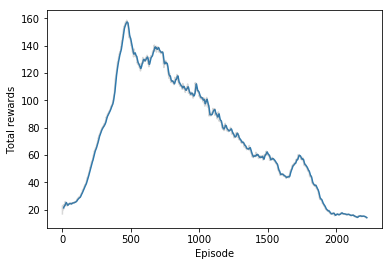

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

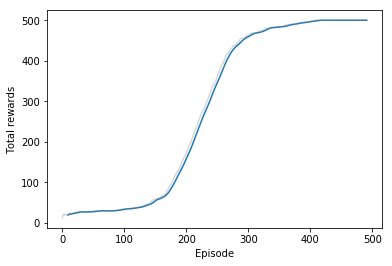

In [62]:
# eps, arr = np.array(episode_rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

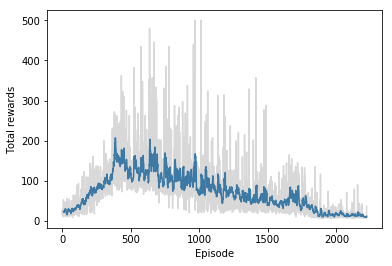

In [17]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

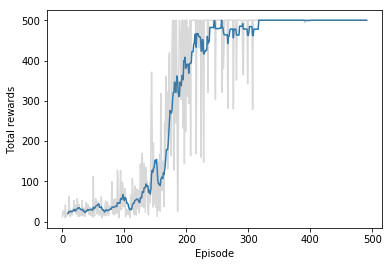

In [63]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [ ]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')`

In [ ]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.